In [61]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from itertools import product

# ======================
# 1. Optimized Data Loading
# ======================

conditions = {
    'All_Heritable': 'ORF_Matrix_All_Heritable.xlsx',
    'No_High': 'no_high_heritable.xlsx',
    'No_Moderate': 'no_moderate_heritable.xlsx',
    'No_Moderate_or_High': 'no_moderate_or_high_heritable.xlsx'
}

# Load all data with condition tracking
dfs = []
for cond, file in conditions.items():
    df = pd.read_excel(file, index_col='AnimalID')
    df['Condition'] = cond  # Add condition label
    dfs.append(df)

combined_df = pd.concat(dfs)
genes = [col for col in combined_df.columns if col != 'Condition']

# ======================
# 2. Enhanced Network Construction
# ======================

# Compute combined correlation matrix
corr_matrix = combined_df[genes].corr().abs()

# Create weighted graph (edge weight = number of conditions where correlation > threshold)
threshold = 0.5
G = nx.Graph()

for cond in conditions:
    # Get data for current condition
    cond_df = combined_df[combined_df['Condition'] == cond][genes]

    # Calculate correlation matrix
    corr_matrix = cond_df.corr().abs()

    # Add edges with weight counting across conditions
    for i, j in product(corr_matrix.columns, repeat=2):
        if i < j and corr_matrix.loc[i, j] > threshold:
            if G.has_edge(i, j):
                G[i][j]['weight'] += 1
            else:
                G.add_edge(i, j, weight=1)

# ======================
# 3. Advanced Community Detection
# ======================

# Louvain with resolution tuning
partition = community_louvain.best_partition(G, resolution=0.8)

# Calculate modularity
modularity = community_louvain.modularity(partition, G)
print(f"Network Modularity: {modularity:.3f}")

# ======================
# 4. Centrality Analysis
# ======================

# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Create node attributes
nx.set_node_attributes(G, partition, 'community')
nx.set_node_attributes(G, degree_centrality, 'degree')
nx.set_node_attributes(G, betweenness_centrality, 'betweenness')


Network Modularity: 0.237


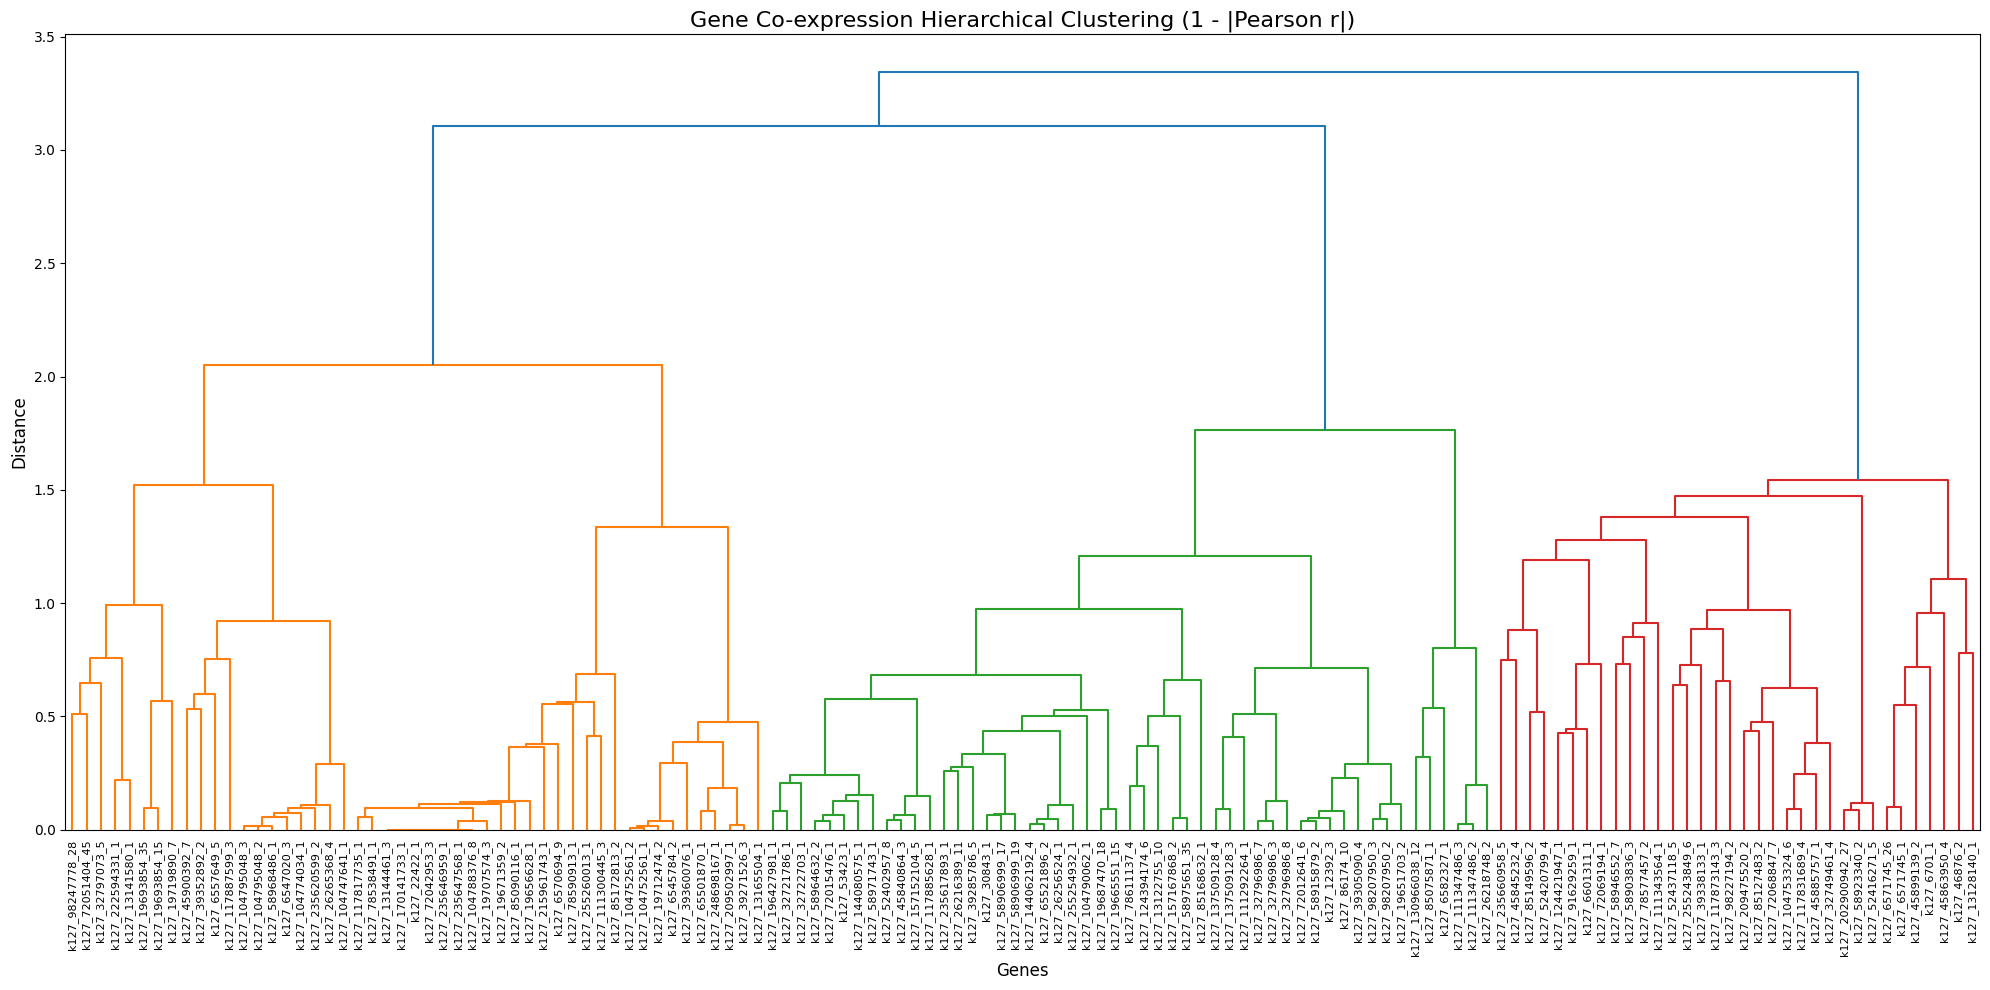

In [44]:
# ======================
# 5. Dendrogram Visualization (Working Version)
# ======================

# Compute correlation matrix with NaN handling
corr_matrix = combined_df[genes].corr(method='pearson', numeric_only=True, min_periods=1).abs()

# Fill NaN values (from constant genes) with 0 correlation
corr_matrix.fillna(0, inplace=True)

# Create condensed distance matrix from upper triangle
upper_tri_indices = np.triu_indices_from(corr_matrix, k=1)
condensed_distances = 1 - corr_matrix.values[upper_tri_indices]

# Verify finite values
assert np.all(np.isfinite(condensed_distances)), "Distance matrix contains non-finite values"

# Hierarchical clustering
linked = linkage(condensed_distances, method='ward')

# Plot dendrogram
plt.figure(figsize=(20, 10))
dendrogram(linked,
           orientation='top',
           labels=corr_matrix.columns.tolist(),
           distance_sort='descending',
           leaf_rotation=90,
           leaf_font_size=8,
           show_leaf_counts=True)
plt.title('Gene Co-expression Hierarchical Clustering (1 - |Pearson r|)', fontsize=16)
plt.xlabel('Genes', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.show()

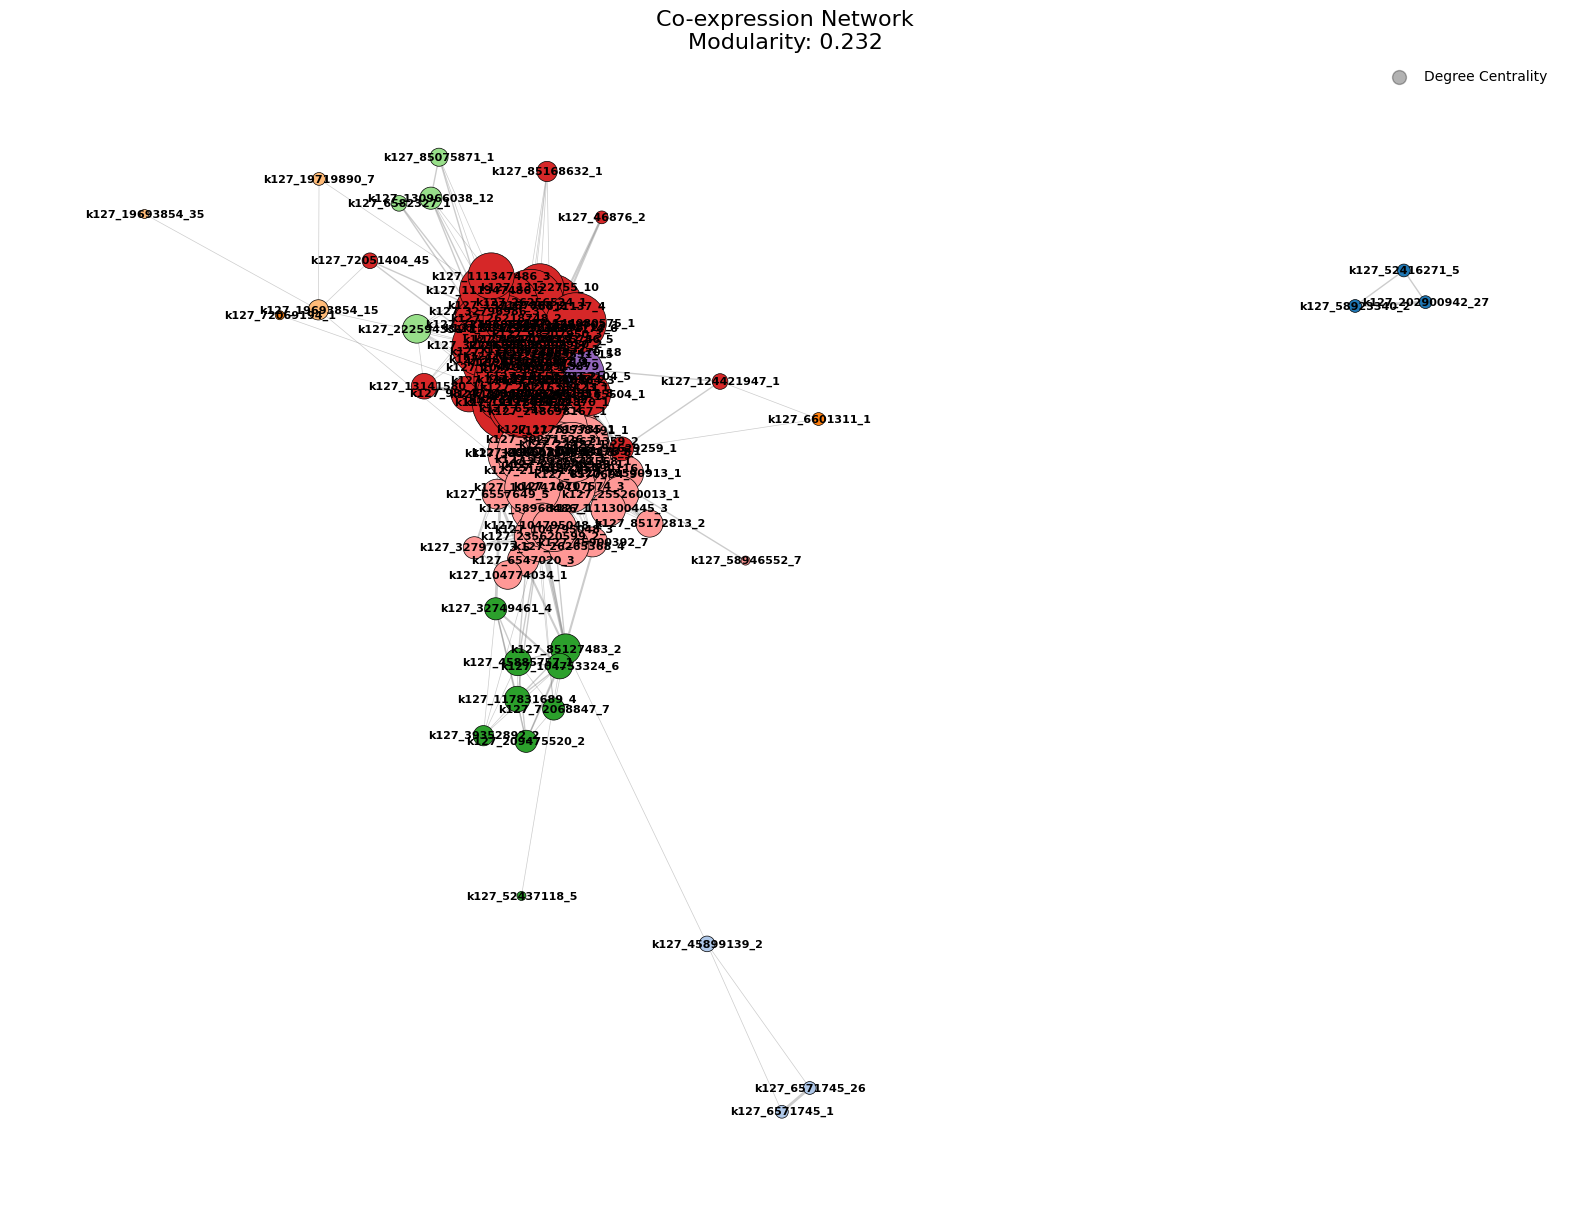

In [45]:

# ======================
# 6. Enhanced Network Visualization
# ======================

# Color mapping
cmap = plt.cm.tab20
community_colors = [cmap(partition[node] % 20) for node in G.nodes()]

# Node size by degree centrality
sizes = [5000 * degree_centrality[node] for node in G.nodes()]

plt.figure(figsize=(20, 15))
pos = nx.spring_layout(G, k=0.3, iterations=100, seed=42)
nx.draw_networkx_nodes(G, pos,
                       node_color=community_colors,
                       node_size=sizes,
                       edgecolors='black',
                       linewidths=0.5)
nx.draw_networkx_edges(G, pos,
                       edge_color='gray',
                       width=[0.5 * G[u][v]['weight'] for u, v in G.edges()],
                       alpha=0.4)
nx.draw_networkx_labels(G, pos,
                        font_size=8,
                        font_weight='bold')
plt.title(f"Co-expression Network\nModularity: {modularity:.3f}", fontsize=16)
plt.axis('off')

# Add centrality legend
plt.scatter([], [], c='k', alpha=0.3, s=100, label='Degree Centrality')
plt.legend(scatterpoints=1,
           frameon=False,
           labelspacing=1.5,
           loc='best')
plt.show()

In [46]:

# ======================
# 7. Community Analysis
# ======================

# Print community statistics
communities = {}
for node, comm_id in partition.items():
    communities.setdefault(comm_id, []).append(node)

print("\nCommunity Analysis:")
for comm_id, members in communities.items():
    print(f"\nCommunity {comm_id} ({len(members)} genes):")
    print(f"Top Hub Genes (Degree Centrality):")
    sorted_members = sorted(members,
                            key=lambda x: degree_centrality[x],
                            reverse=True)[:5]
    for gene in sorted_members:
        print(f"- {gene}: Degree={degree_centrality[gene]:.3f}, Betweenness={betweenness_centrality[gene]:.3f}")


Community Analysis:

Community 7 (36 genes):
Top Hub Genes (Degree Centrality):
- k127_6545784_2: Degree=0.610, Betweenness=0.042
- k127_248698167_1: Degree=0.593, Betweenness=0.040
- k127_209502997_1: Degree=0.466, Betweenness=0.022
- k127_39271526_3: Degree=0.458, Betweenness=0.020
- k127_117817735_1: Degree=0.432, Betweenness=0.017

Community 6 (58 genes):
Top Hub Genes (Degree Centrality):
- k127_19712474_2: Degree=0.602, Betweenness=0.027
- k127_104752561_1: Degree=0.602, Betweenness=0.027
- k127_104752561_2: Degree=0.602, Betweenness=0.028
- k127_32721786_1: Degree=0.576, Betweenness=0.020
- k127_72012641_6: Degree=0.551, Betweenness=0.010

Community 4 (9 genes):
Top Hub Genes (Degree Centrality):
- k127_85127483_2: Degree=0.093, Betweenness=0.060
- k127_45885757_1: Degree=0.076, Betweenness=0.008
- k127_117831689_4: Degree=0.068, Betweenness=0.003
- k127_104753324_6: Degree=0.068, Betweenness=0.022
- k127_32749461_4: Degree=0.051, Betweenness=0.014

Community 8 (1 genes):
Top H

In [47]:
# Initialize DataFrame to store metrics
condition_metrics = pd.DataFrame(columns=['Condition', 'Modularity', 'Density', 'AvgClustering'])

for cond in conditions:
    # Subset data for condition
    cond_df = combined_df[combined_df['Condition'] == cond][genes]

    # Build condition-specific correlation network
    corr_matrix = cond_df.corr().abs()
    G_cond = nx.Graph()
    G_cond.add_edges_from([(i, j) for i, j in product(corr_matrix.columns, repeat=2)
                          if i < j and corr_matrix.loc[i, j] > threshold])

    # Compute metrics
    partition_cond = community_louvain.best_partition(G_cond)
    modularity = community_louvain.modularity(partition_cond, G_cond)
    density = nx.density(G_cond)
    avg_clustering = nx.average_clustering(G_cond)

    # Store results
    condition_metrics = pd.concat([condition_metrics, pd.DataFrame([{
        'Condition': cond,
        'Modularity': modularity,
        'Density': density,
        'AvgClustering': avg_clustering
    }])])

print("\nCondition-Specific Network Metrics:")
print(condition_metrics.reset_index(drop=True))

<ipython-input-47-5191409c16ab>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  condition_metrics = pd.concat([condition_metrics, pd.DataFrame([{



Condition-Specific Network Metrics:
             Condition  Modularity   Density  AvgClustering
0        All_Heritable    0.254751  0.277168       0.742206
1              No_High    0.223042  0.371128       0.709490
2          No_Moderate    0.198829  0.426984       0.707141
3  No_Moderate_or_High    0.238649  0.318836       0.765841


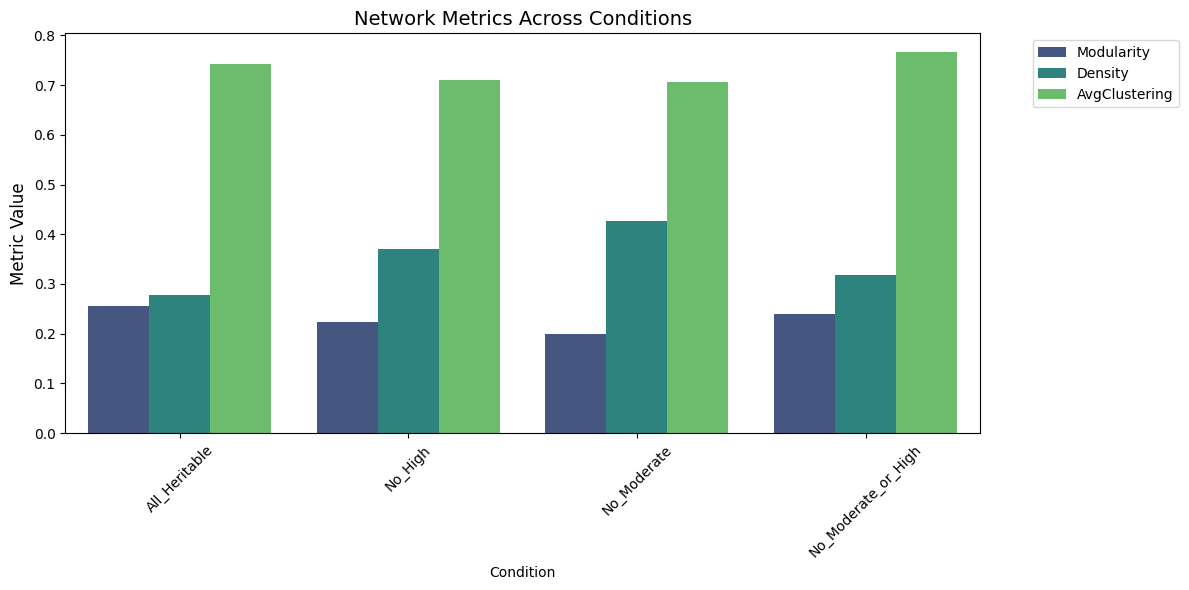

In [48]:
# After computing condition_metrics DataFrame
import seaborn as sns

# Melt for seaborn plotting
melted_metrics = pd.melt(condition_metrics, id_vars='Condition',
                        value_vars=['Modularity', 'Density', 'AvgClustering'],
                        var_name='Metric', value_name='Value')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_metrics, x='Condition', y='Value', hue='Metric', palette='viridis')
plt.title('Network Metrics Across Conditions', fontsize=14)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [49]:
# Build edge sets for each condition
edge_sets = {}
for cond in conditions:
    cond_df = combined_df[combined_df['Condition'] == cond][genes]
    corr_matrix = cond_df.corr().abs()
    edges = set(frozenset((i, j)) for i, j in product(corr_matrix.columns, repeat=2)
                if i < j and corr_matrix.loc[i, j] > threshold)
    edge_sets[cond] = edges

# Compare all pairs of conditions
for cond1, cond2 in product(conditions, repeat=2):
    if cond1 != cond2:
        intersection = len(edge_sets[cond1] & edge_sets[cond2])
        union = len(edge_sets[cond1] | edge_sets[cond2])
        jaccard = intersection / union if union != 0 else 0
        print(f"Jaccard Index ({cond1} vs {cond2}): {jaccard:.3f}")

Jaccard Index (All_Heritable vs No_High): 0.326
Jaccard Index (All_Heritable vs No_Moderate): 0.138
Jaccard Index (All_Heritable vs No_Moderate_or_High): 0.558
Jaccard Index (No_High vs All_Heritable): 0.326
Jaccard Index (No_High vs No_Moderate): 0.424
Jaccard Index (No_High vs No_Moderate_or_High): 0.358
Jaccard Index (No_Moderate vs All_Heritable): 0.138
Jaccard Index (No_Moderate vs No_High): 0.424
Jaccard Index (No_Moderate vs No_Moderate_or_High): 0.248
Jaccard Index (No_Moderate_or_High vs All_Heritable): 0.558
Jaccard Index (No_Moderate_or_High vs No_High): 0.358
Jaccard Index (No_Moderate_or_High vs No_Moderate): 0.248


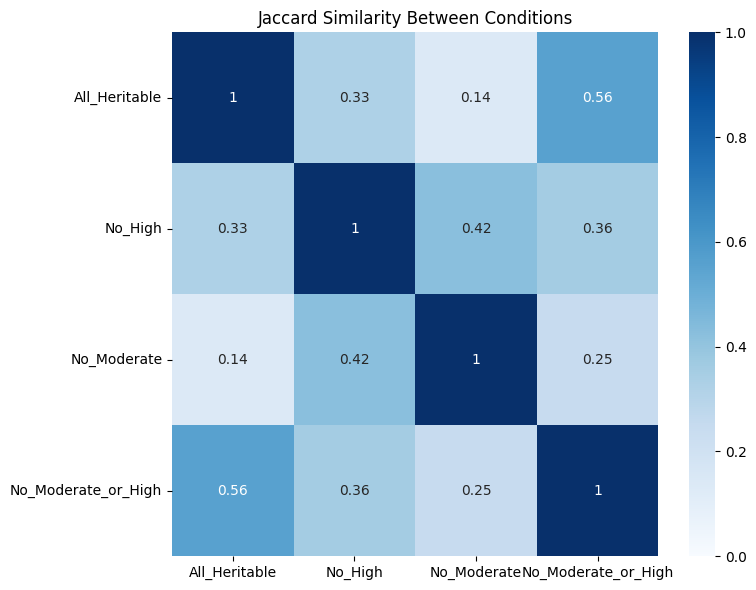

In [50]:
# After calculating edge overlaps
from matplotlib_venn import venn2, venn3

# Heatmap for Jaccard similarity
jaccard_matrix = pd.DataFrame(index=conditions, columns=conditions)
for cond1, cond2 in product(conditions, repeat=2):
    intersection = len(edge_sets[cond1] & edge_sets[cond2])
    union = len(edge_sets[cond1] | edge_sets[cond2])
    jaccard_matrix.loc[cond1, cond2] = intersection / union if union != 0 else 0

plt.figure(figsize=(8, 6))
sns.heatmap(jaccard_matrix.astype(float), annot=True, cmap='Blues', vmin=0, vmax=1)
plt.title('Jaccard Similarity Between Conditions', fontsize=12)
plt.tight_layout()
plt.show()

In [51]:
# Track degree centrality across conditions
centrality_shifts = {}
for gene in genes:
    centrality_shifts[gene] = {}

for cond in conditions:
    cond_df = combined_df[combined_df['Condition'] == cond][genes]
    corr_matrix = cond_df.corr().abs()
    G_cond = nx.Graph()
    G_cond.add_edges_from([(i, j) for i, j in product(corr_matrix.columns, repeat=2)
                          if i < j and corr_matrix.loc[i, j] > threshold])
    degree_centrality = nx.degree_centrality(G_cond)
    for gene in genes:
        centrality_shifts[gene][cond] = degree_centrality.get(gene, 0)

# Convert to DataFrame and calculate shifts
centrality_df = pd.DataFrame(centrality_shifts).T
centrality_df['High_vs_NoHigh'] = centrality_df['All_Heritable'] - centrality_df['No_High']
print("\nCentrality Shifts (All_Heritable - No_High):")
print(centrality_df[['All_Heritable', 'No_High', 'High_vs_NoHigh']].sort_values('High_vs_NoHigh', ascending=False))


Centrality Shifts (All_Heritable - No_High):
                  All_Heritable   No_High  High_vs_NoHigh
k127_19712474_2        0.601695  0.000000        0.601695
k127_196427981_1       0.542373  0.000000        0.542373
k127_117885628_1       0.516949  0.000000        0.516949
k127_58964632_2        0.508475  0.000000        0.508475
k127_86174_10          0.483051  0.000000        0.483051
...                         ...       ...             ...
k127_32721786_1        0.576271  0.672414       -0.096143
k127_248698167_1       0.593220  0.689655       -0.096435
k127_65501870_1        0.550847  0.655172       -0.104325
k127_117817735_1       0.432203  0.551724       -0.119521
k127_78538491_1        0.288136  0.413793       -0.125658

[134 rows x 3 columns]


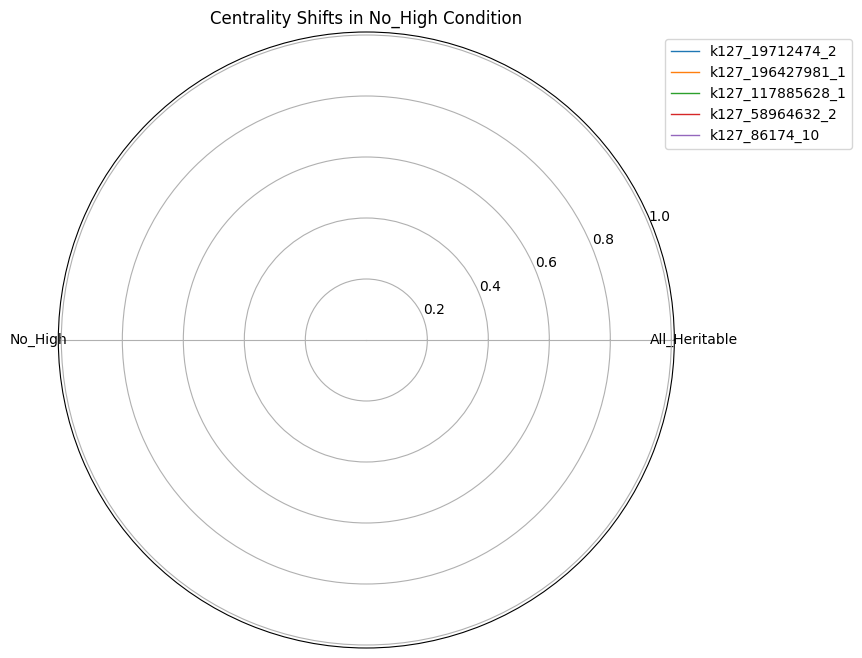

In [52]:
# After centrality_df is computed
from math import pi

# Select top 5 genes with largest centrality drop in No_High
top_genes = centrality_df.nlargest(5, 'High_vs_NoHigh').index

# Normalize centrality values
normalized = centrality_df.loc[top_genes, ['All_Heritable', 'No_High']].apply(lambda x: x/x.max(), axis=0)

# Plot radar chart
categories = list(normalized.columns)
N = len(categories)
angles = [n / N * 2 * pi for n in range(N)]
angles += angles[:1]  # Close the plot

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
for gene in top_genes:
    values = normalized.loc[gene].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=gene)
    ax.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], categories)
plt.title('Centrality Shifts in No_High Condition', fontsize=12)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

In [53]:
from sklearn.metrics import adjusted_mutual_info_score

# Detect communities for each condition
community_assignments = {}
for cond in conditions:
    cond_df = combined_df[combined_df['Condition'] == cond][genes]
    corr_matrix = cond_df.corr().abs()
    G_cond = nx.Graph()
    G_cond.add_edges_from([(i, j) for i, j in product(corr_matrix.columns, repeat=2)
                          if i < j and corr_matrix.loc[i, j] > threshold])
    partition_cond = community_louvain.best_partition(G_cond)
    community_assignments[cond] = partition_cond

# Compare communities using NMI
for cond1, cond2 in product(conditions, repeat=2):
    if cond1 != cond2:
        labels1 = [community_assignments[cond1].get(gene, -1) for gene in genes]
        labels2 = [community_assignments[cond2].get(gene, -1) for gene in genes]
        nmi = adjusted_mutual_info_score(labels1, labels2)
        print(f"NMI ({cond1} vs {cond2}): {nmi:.3f}")

NMI (All_Heritable vs No_High): 0.308
NMI (All_Heritable vs No_Moderate): 0.176
NMI (All_Heritable vs No_Moderate_or_High): 0.494
NMI (No_High vs All_Heritable): 0.308
NMI (No_High vs No_Moderate): 0.542
NMI (No_High vs No_Moderate_or_High): 0.291
NMI (No_Moderate vs All_Heritable): 0.176
NMI (No_Moderate vs No_High): 0.542
NMI (No_Moderate vs No_Moderate_or_High): 0.321
NMI (No_Moderate_or_High vs All_Heritable): 0.494
NMI (No_Moderate_or_High vs No_High): 0.291
NMI (No_Moderate_or_High vs No_Moderate): 0.321


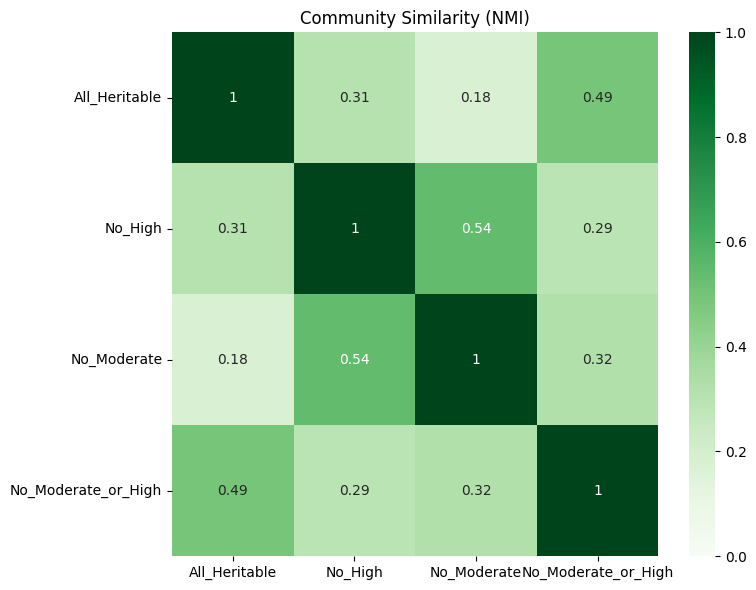

In [54]:
# After computing NMI scores
nmi_matrix = pd.DataFrame(index=conditions, columns=conditions)
for cond1, cond2 in product(conditions, repeat=2):
    labels1 = [community_assignments[cond1].get(gene, -1) for gene in genes]
    labels2 = [community_assignments[cond2].get(gene, -1) for gene in genes]
    nmi_matrix.loc[cond1, cond2] = adjusted_mutual_info_score(labels1, labels2)

plt.figure(figsize=(8, 6))
sns.heatmap(nmi_matrix.astype(float), annot=True, cmap='Greens', vmin=0, vmax=1)
plt.title('Community Similarity (NMI)', fontsize=12)
plt.tight_layout()
plt.show()

In [55]:
import numpy as np
import scipy.stats as stats  # Add this import
import statsmodels.stats.multitest as multi

# Get data for two conditions to compare
cond1_df = combined_df[combined_df['Condition'] == 'All_Heritable'][genes]
cond2_df = combined_df[combined_df['Condition'] == 'No_Moderate'][genes]

# Compute correlations
corr1 = cond1_df.corr().abs().stack().reset_index(name='corr1')
corr2 = cond2_df.corr().abs().stack().reset_index(name='corr2')
merged = pd.merge(corr1, corr2, on=['level_0', 'level_1']).query('level_0 < level_1')

# Fisher's z-test using numpy's arctanh (equivalent to Fisher z-transform)
merged['z1'] = merged['corr1'].apply(lambda r: np.arctanh(r))  # Fix here
merged['z2'] = merged['corr2'].apply(lambda r: np.arctanh(r))  # Fix here
merged['z_diff'] = (merged['z1'] - merged['z2']) / np.sqrt(1/(len(cond1_df)-3) + 1/(len(cond2_df)-3))
merged['p_value'] = 2 * (1 - stats.norm.cdf(np.abs(merged['z_diff'])))  # Requires scipy.stats

# Multiple testing correction
merged['p_adj'] = multi.multipletests(merged['p_value'], method='fdr_bh')[1]

# Significant pairs (FDR < 0.05)
sig_pairs = merged[merged['p_adj'] < 0.05]
print(f"\nSignificantly Different Correlations (n={len(sig_pairs)}):")
print(sig_pairs.sort_values('p_adj'))


Significantly Different Correlations (n=0):
Empty DataFrame
Columns: [level_0, level_1, corr1, corr2, z1, z2, z_diff, p_value, p_adj]
Index: []


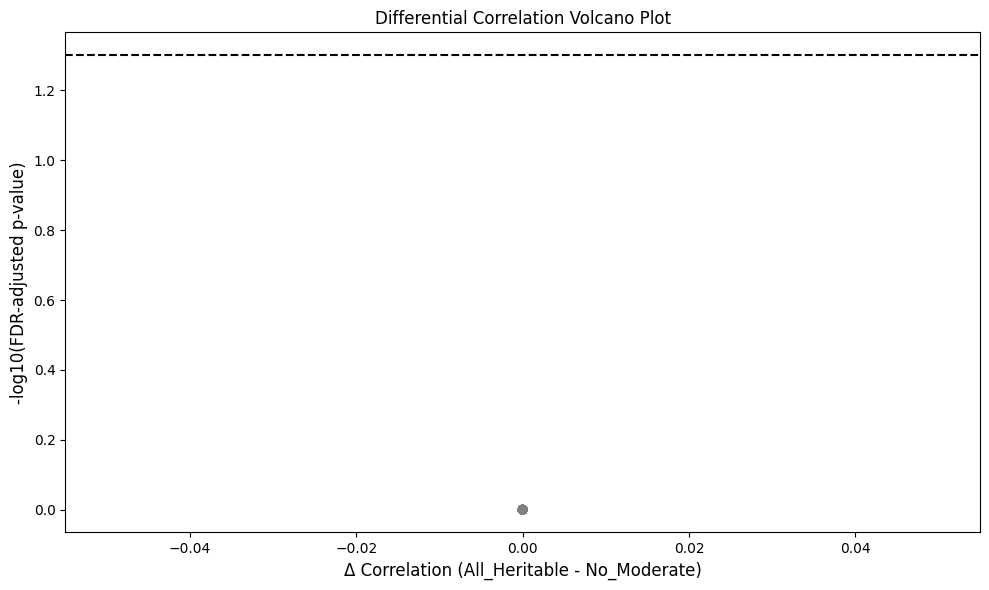

In [56]:
# After differential correlation analysis
plt.figure(figsize=(10, 6))
plt.scatter(merged['corr1'] - merged['corr2'], -np.log10(merged['p_adj']),
            c=np.where(merged['p_adj'] < 0.05, 'red', 'grey'), alpha=0.5)
plt.xlabel('Δ Correlation (All_Heritable - No_Moderate)', fontsize=12)
plt.ylabel('-log10(FDR-adjusted p-value)', fontsize=12)
plt.title('Differential Correlation Volcano Plot', fontsize=12)
plt.axhline(-np.log10(0.05), linestyle='--', color='k')
plt.tight_layout()
plt.show()

In [57]:
# Compare No_High vs No_Moderate networks
edge_diff = len(edge_sets['No_High'] ^ edge_sets['No_Moderate'])
print(f"\nEdge Difference (No_High vs No_Moderate): {edge_diff} edges")

# Compare density changes
density_high = condition_metrics[condition_metrics['Condition'] == 'No_High']['Density'].values[0]
density_mod = condition_metrics[condition_metrics['Condition'] == 'No_Moderate']['Density'].values[0]
print(f"Density Change: No_High ({density_high:.3f}) vs No_Moderate ({density_mod:.3f})")


Edge Difference (No_High vs No_Moderate): 366 edges
Density Change: No_High (0.371) vs No_Moderate (0.427)


<ipython-input-58-df5bc8a9b784>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(edge_counts.keys()), y=list(edge_counts.values()), palette='rocket')


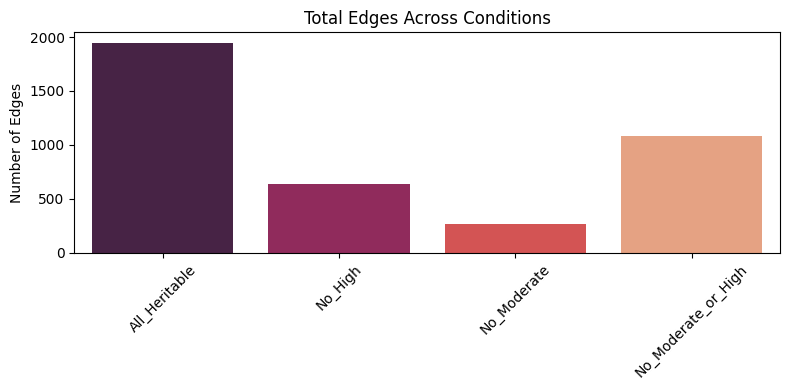

In [58]:
# Compare edge counts across conditions
edge_counts = {cond: len(edges) for cond, edges in edge_sets.items()}
plt.figure(figsize=(8, 4))
sns.barplot(x=list(edge_counts.keys()), y=list(edge_counts.values()), palette='rocket')
plt.title('Total Edges Across Conditions', fontsize=12)
plt.ylabel('Number of Edges', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [59]:
# Find edges present in ALL conditions
core_edges = set.intersection(*edge_sets.values())
print(f"\nCore Edges (n={len(core_edges)}):")
print([tuple(edge) for edge in list(core_edges)[:5]])  # Print first 5

# Find edges unique to each condition
peripheral_edges = {}
for cond in conditions:
    unique = edge_sets[cond] - set.union(*[edge_sets[c] for c in conditions if c != cond])
    peripheral_edges[cond] = unique
    print(f"\nPeripheral Edges in {cond} (n={len(unique)}):")
    print([tuple(edge) for edge in list(unique)[:5]])


Core Edges (n=269):
[('k127_19665551_15', 'k127_32721786_1'), ('k127_39271526_3', 'k127_215961743_1'), ('k127_111292264_1', 'k127_58906999_17'), ('k127_58915879_2', 'k127_104752561_2'), ('k127_248698167_1', 'k127_6570694_9')]

Peripheral Edges in All_Heritable (n=679):
[('k127_65501870_1', 'k127_196427981_1'), ('k127_98247778_28', 'k127_86174_10'), ('k127_72012641_6', 'k127_157167868_2'), ('k127_6545784_2', 'k127_209502997_1'), ('k127_6570694_9', 'k127_39360076_1')]

Peripheral Edges in No_High (n=0):
[]

Peripheral Edges in No_Moderate (n=0):
[]

Peripheral Edges in No_Moderate_or_High (n=0):
[]


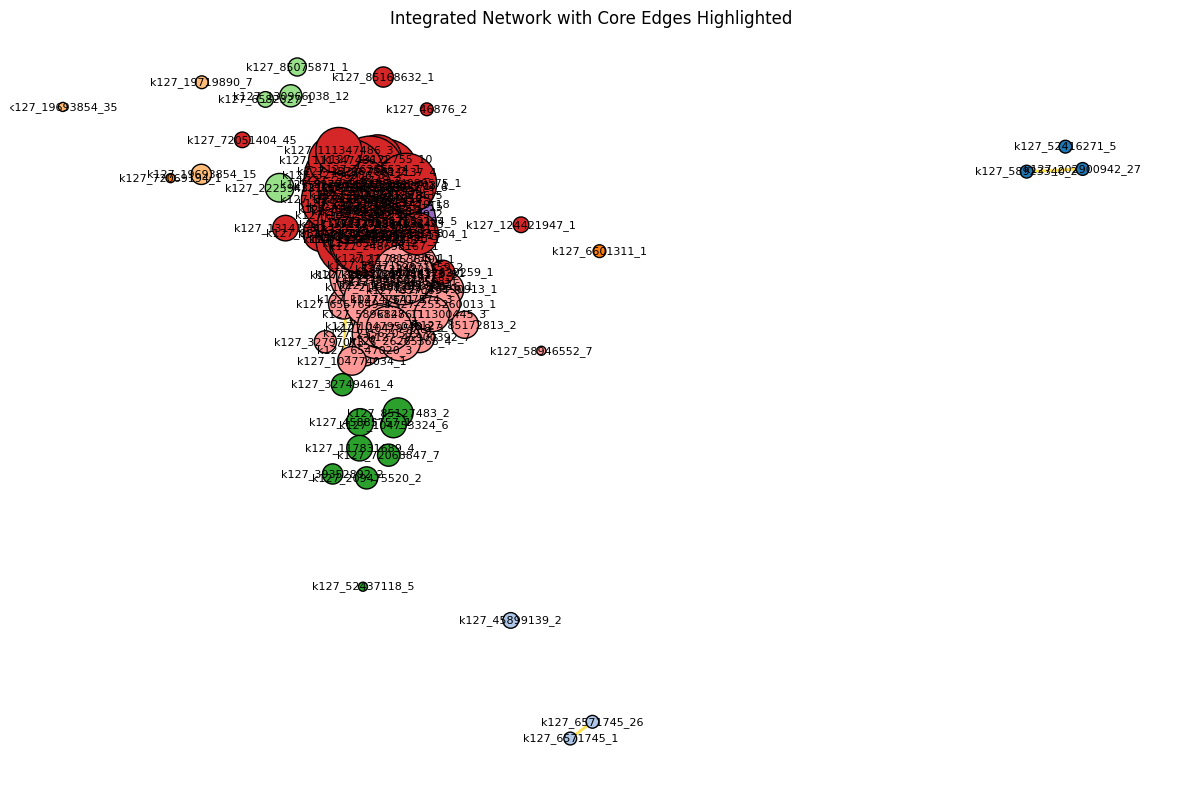

In [60]:
# Highlight core edges in the integrated network
core_edge_list = [tuple(edge) for edge in core_edges]

plt.figure(figsize=(15, 10))
nx.draw_networkx_edges(G, pos, edgelist=core_edge_list, edge_color='gold', width=2, alpha=0.7)
nx.draw_networkx_nodes(G, pos, node_color=community_colors, node_size=sizes, edgecolors='black')
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title('Integrated Network with Core Edges Highlighted', fontsize=12)
plt.axis('off')
plt.show()